# Проект: Анализ производительности коров фермы и рекомендации по покупке новых коров

В ходе работы над проектом, необходимо провести анализ продоставленных данных по производительности стада коров. Заказчиком предоставлено 3 датасета:
- первый содержит данные о стаде фермера на текущий момент;
- второй хранит имя папы каждой коровы в стаде фермера;
- данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

План работы:
- загрузить данные и посмотреть как они представлены;
- все 3 датасета изучить на наличие пропусков и дубликатов, при их обнаружении обработать так, чтобы не возникало искусственных данных;
- провести исследовательский анализ, а именно выделить признаки из 1 датасета и построить их графики с учетом, что для количественных данных и категориальных подходят разные виды визуализации;
- провести корреляционный анализ: найти коэффициенты корреляции между всеми признаками и построить диагрммы рассеяния;
- реализовать 3 модели линейной регрессии, чтобы в каждой отследить свои плюсы и минусы, посчитать метрики и выбрать лучшую для прогноза удоя, имеющихся коров;
- обучить модель логистической регрессии для оценки вкуса молока коров, посчитать метрики и по возможности провести корректировку модели для уменьшения ошибок;
- сделать выводы по проделанной работе

In [1]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


## Загрузка данных

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error, accuracy_score, recall_score,
                             precision_score, confusion_matrix)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

In [3]:
# Для скрытия предупреждений
import warnings
warnings.filterwarnings('ignore')

In [4]:
try:
    data_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
    data_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')
    data_buy = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')
except:
    data_main = pd.read_csv('ferma_main.csv', sep=';', decimal=',')
    data_dad = pd.read_csv('ferma_dad.csv', sep=';', decimal=',')
    data_buy = pd.read_csv('cow_buy.csv', sep=';', decimal=',')

**Вывод общей информации в датасетах**

In [5]:
data_main.info()
start_shape = data_main.shape[0]
start_shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

634

In [6]:
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [7]:
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**Вывод первых 5 строк**

In [8]:
data_main.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [9]:
data_dad.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [10]:
data_buy.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


**Обработка названий столбцов**

In [11]:
data_main = data_main.rename(columns = {'Удой, кг':'удой_кг',
                                        'ЭКЕ (Энергетическая кормовая единица)':'эке_энергетическая_кормовая_единица',
                                        'Сырой протеин, г':'cырой_протеин_г',
                                        'СПО (Сахаро-протеиновое соотношение)':'спо_сахаро_протеиновое_соотношение',
                                        'Порода':'порода',
                                        'Тип пастбища':'тип_пастбища',
                                        'порода папы_быка':'порода_папы_быка',
                                        'Жирность,%':'жирность_%',
                                        'Белок,%':'белок_%',
                                        'Вкус молока':'вкус_молока',
                                        'Возраст':'возраст'})

In [12]:
data_dad = data_dad.rename(columns = {'Имя Папы':'имя_папы'})

In [13]:
data_buy = data_buy.rename(columns = {'Порода':'порода',
                                      'Тип пастбища':'тип_пастбища',
                                      'порода папы_быка':'порода_папы_быка',
                                      'Имя_папы':'имя_папы',
                                      'Текущая_жирность,%':'текущая_жирность_%',
                                      'Текущий_уровень_белок,%':'текущий_уровень_белок_%',
                                      'Возраст':'возраст'})

**Проверка на корректность изменения имени столбцов**

In [14]:
data_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   634 non-null    int64  
 1   удой_кг                              634 non-null    int64  
 2   эке_энергетическая_кормовая_единица  634 non-null    float64
 3   cырой_протеин_г                      634 non-null    int64  
 4   спо_сахаро_протеиновое_соотношение   634 non-null    float64
 5   порода                               634 non-null    object 
 6   тип_пастбища                         634 non-null    object 
 7   порода_папы_быка                     634 non-null    object 
 8   жирность_%                           634 non-null    float64
 9   белок_%                              634 non-null    float64
 10  вкус_молока                          634 non-null    object 
 11  возраст                         

In [15]:
data_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя_папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [16]:
data_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип_пастбища             20 non-null     object 
 2   порода_папы_быка         20 non-null     object 
 3   имя_папы                 20 non-null     object 
 4   текущая_жирность_%       20 non-null     float64
 5   текущий_уровень_белок_%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**Вывод по первому шагу: Данные в таблицах находились в не пригодном к анализу виде, поэтому использован специальный формат загрузки данных, первый из которых корректно разделит все значения по столбцам, а второй преобразует вещественные числа в формат с точкой для необходимости проводить математические операции над ними. Также названия практически всех столбцов были в неправильной для анализа форме, было произведено изменение названий столбцов.**

##  Предобработка данных

### Пропущенные значения

<AxesSubplot:>

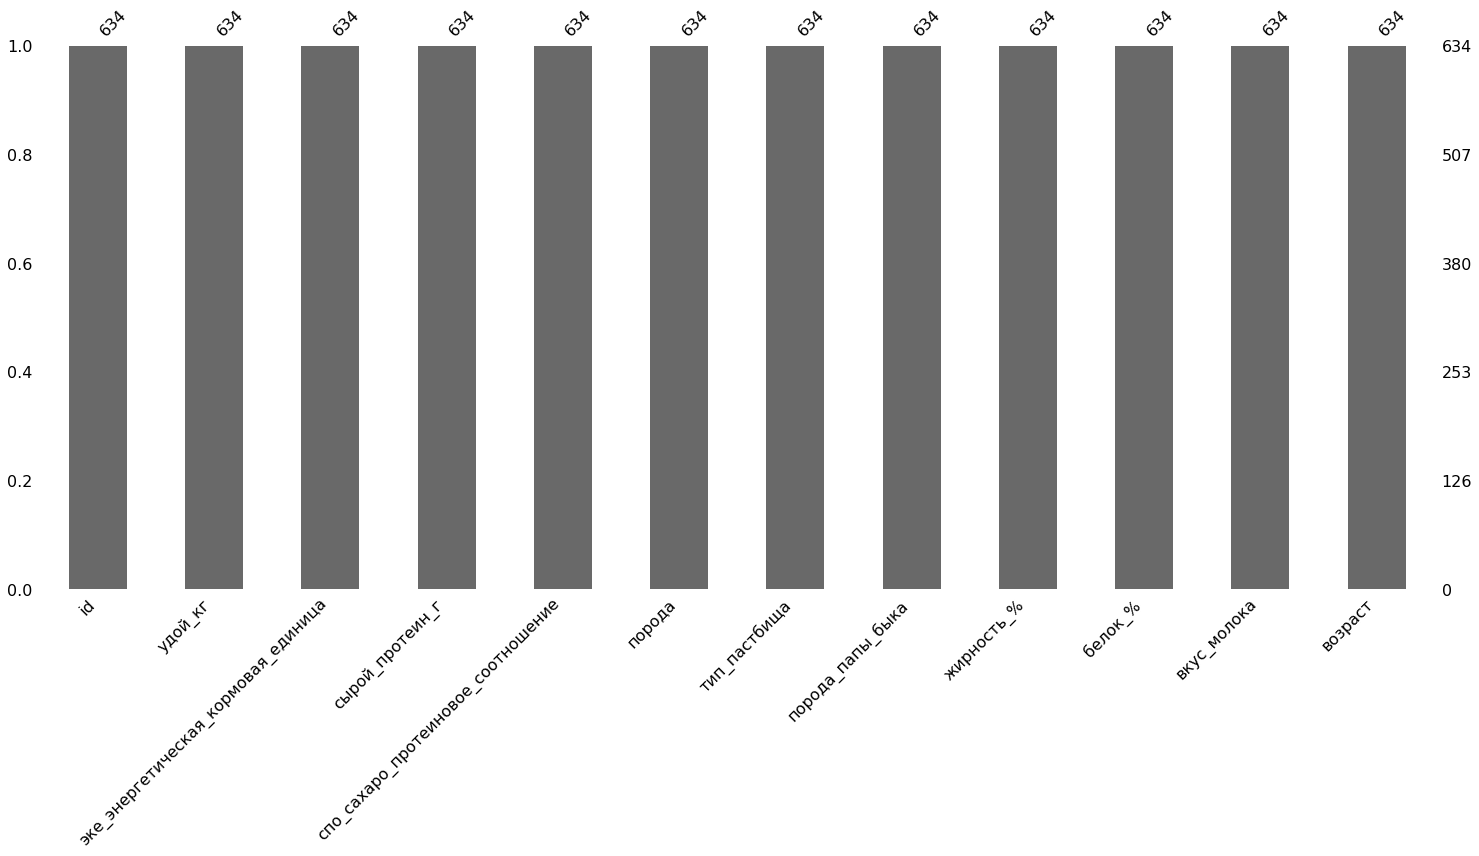

In [17]:
msno.bar(data_main)

<AxesSubplot:>

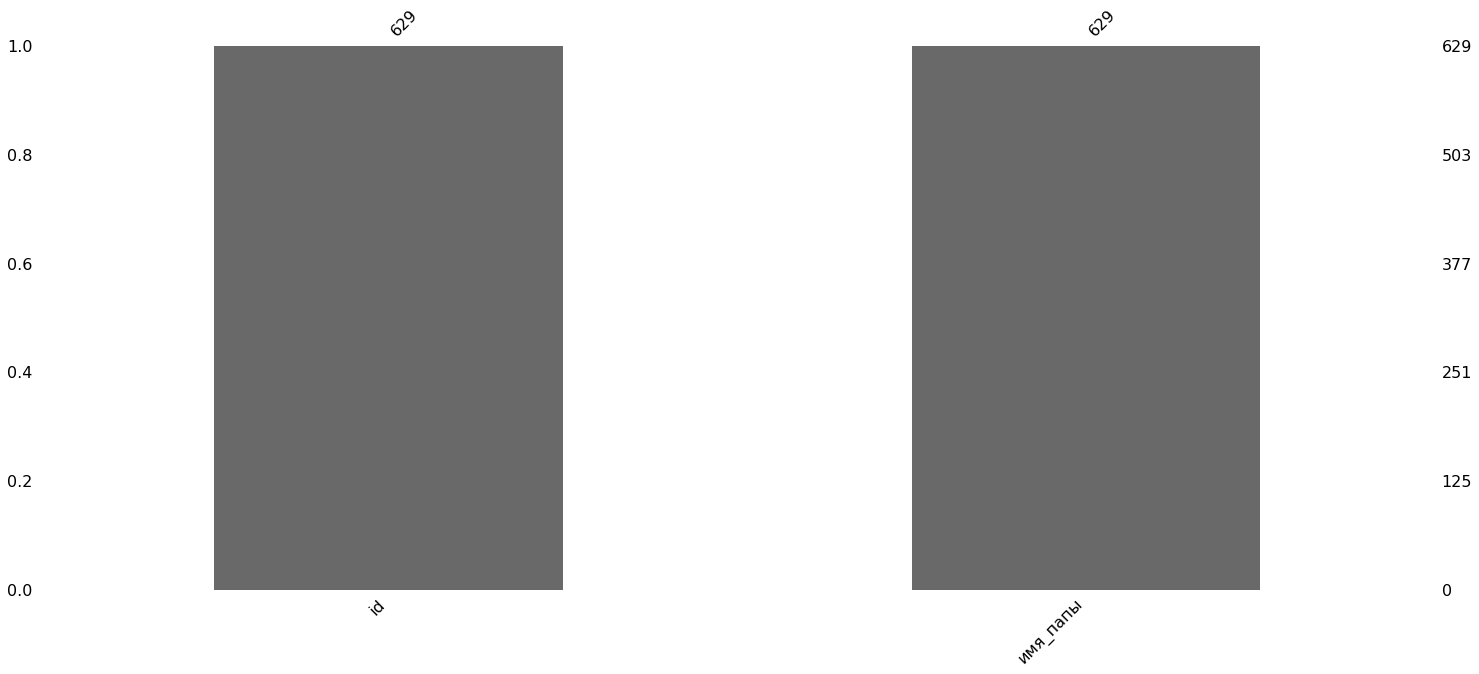

In [18]:
msno.bar(data_dad)

<AxesSubplot:>

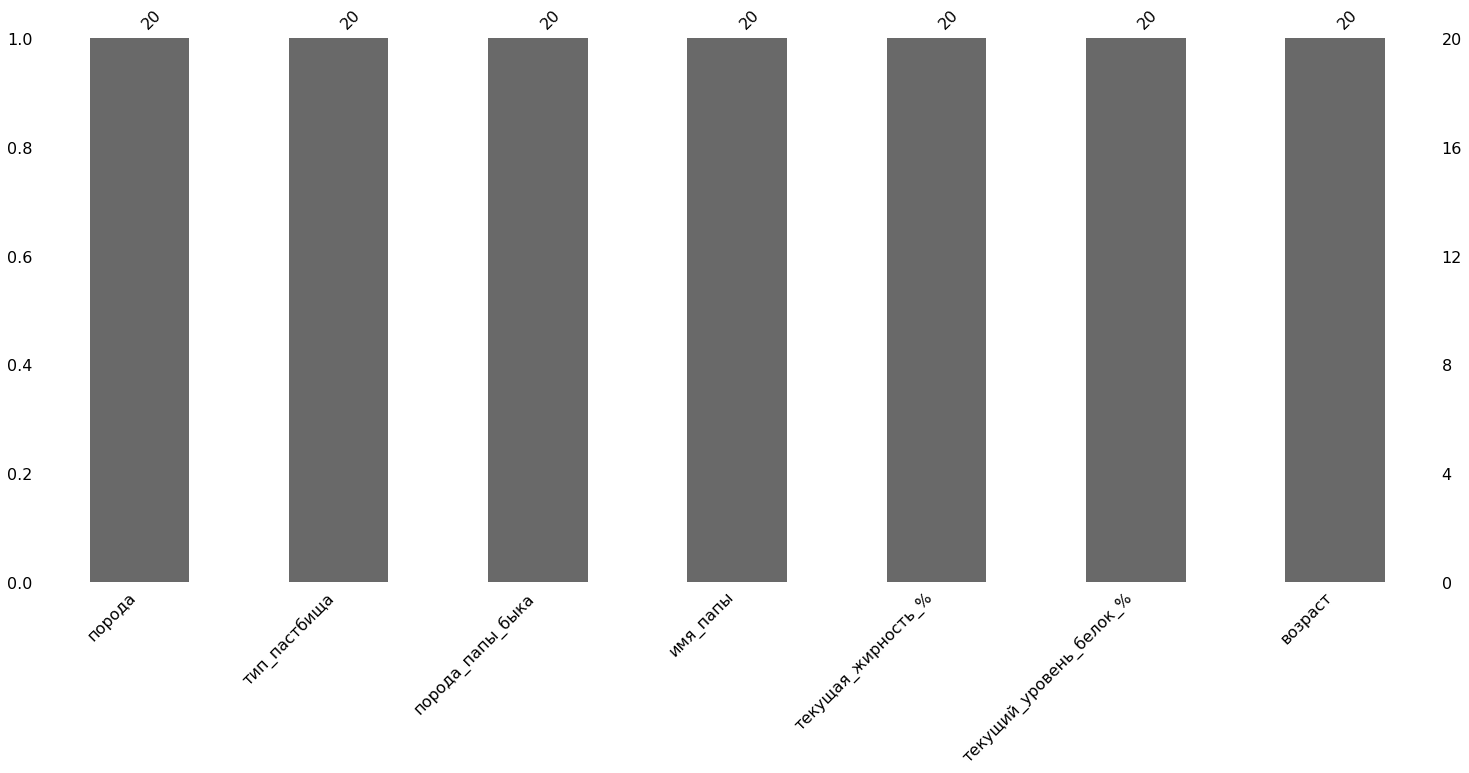

In [19]:
msno.bar(data_buy)

**Наглядно можно убедиться, что пропусков в таблицах нету**

### Проверка на дубликаты

In [20]:
print(data_main.duplicated().sum())
data_main.tail()

5


,id,удой_кг,эке_энергетическая_кормовая_единица,cырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


**Видим, что последние 5 строк идентичные, дубликаты можно удалить**

In [21]:
#Проверка на корректность удаления дубликатов
data_main = data_main.drop_duplicates()
print(data_main.shape)
data_main.tail()

(629, 12)


,id,удой_кг,эке_энергетическая_кормовая_единица,cырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст
624,625,6812,15.4,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
625,626,5513,12.9,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
626,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
627,628,5746,13.8,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет
628,629,6503,16.2,2283,0.94,Вис Бик Айдиал,Холмистое,Соверин,3.71,3.076,вкусно,более_2_лет


In [22]:
data_main['тип_пастбища'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

**Обнаружен неявный дубликат Равнинное и Равнинные, поэтому заменим Равнинные на Равнинное.**

In [23]:
data_main['тип_пастбища'] = data_main['тип_пастбища'].replace('Равнинные', 'Равнинное').str.lower()
#Проверка
data_main['тип_пастбища'].unique()

array(['равнинное', 'холмистое'], dtype=object)

In [24]:
data_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

**Видим аналогичную ситуацию.**

In [25]:
data_main['порода_папы_быка'] = data_main['порода_папы_быка'].replace('Айдиалл', 'Айдиал')
#Проверка
data_main['порода_папы_быка'].unique()

array(['Айдиал', 'Соверин'], dtype=object)

In [26]:
data_dad.duplicated().sum()

0

**В данном датасете дубликатов не обнаружено**

In [27]:
print(data_buy.shape)
data_buy.duplicated().sum()

(20, 7)


4

In [28]:
data_buy[data_buy.duplicated()]

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


**Обнаружены дубликаты в 8 и 14 строчках, можно удалить**

In [29]:
#Проверка на корректность удаления дубликатов
data_buy = data_buy.drop(8, axis=0)
data_buy.shape

(19, 7)

**Вывод по второму шагу: Пропущенные значения были проанализивароны с помощью дополнительной библиотеки, построены диаграммы для каждого параметра столбца, пропущенных значений не обнаружено. Проверка на дубликаты обнаружила несколько дубликатов в data_main и data_buy, дубликаты были удалены, а также произведена проверка на корректность их удаления. Обнуружены неявные дубликаты, которые были корректно обработаны.**

## Исследовательский анализ данных

###  Cтатистический анализ всех признаков

In [30]:
data_main.describe()

,id,удой_кг,эке_энергетическая_кормовая_единица,cырой_протеин_г,спо_сахаро_протеиновое_соотношение,жирность_%,белок_%
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


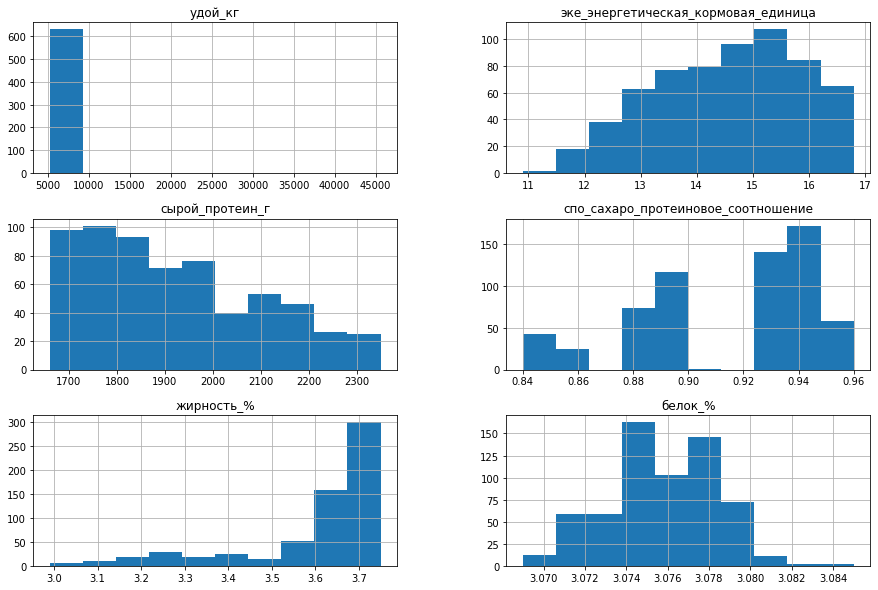

In [31]:
# Гистограммы для числовых признаков
data_main.drop('id', axis=1).hist(figsize=(15, 10))
plt.show()

**Выведена таблица с статистическими параметрами количественных данных, а также построены для них гистограммы.**

**Построение графиков**

In [32]:
# Установка стиля для графиков
sns.set(style="whitegrid")
# Функция для создания гистограммы и коробчатой диаграммы
def plot_distribution(data, column, title):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Гистограмма
    sns.histplot(data[column], kde=True, ax=axes[0])
    axes[0].set_title(f'Гистограмма {title}')
    
    # Коробчатая диаграмма
    sns.boxplot(x=data[column], ax=axes[1])
    axes[1].set_title(f'Диаграмма размаха {title}')
    
    plt.tight_layout()
    plt.show()

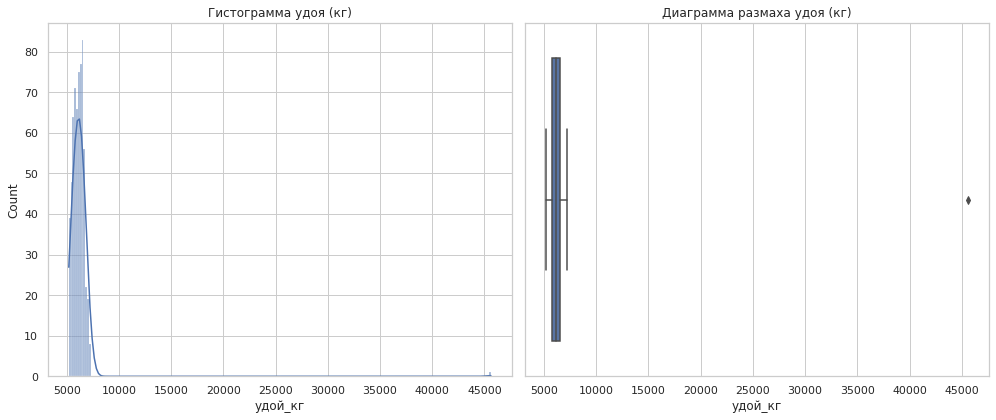

In [33]:
plot_distribution(data_main, 'удой_кг', 'удоя (кг)')

**На диаграмме ящика с усами видим один очень серьезный выброс, с очень высоким значением.**

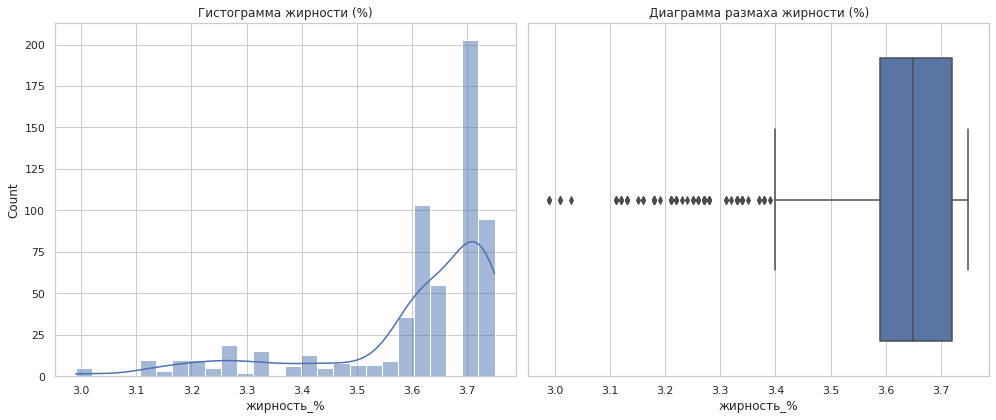

In [34]:
plot_distribution(data_main, 'жирность_%', 'жирности (%)')

**В данном случае также ящик с усами показывает наличие выбросов порядка $10^{-1}$, только уже меньших, чем основные данные. На гистограмме можно заметить отсутствие данных с значеними примерно от 3.65 до 3.7.**

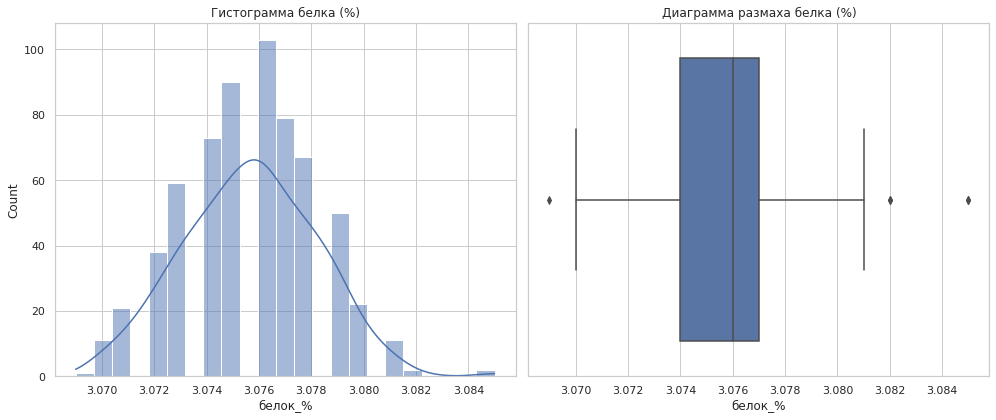

In [35]:
plot_distribution(data_main, 'белок_%', 'белка (%)')

**Гистограмма значений белка очень похожа на нормальное распределение данных, но в ней также присутствуют пробелы. Ящик с усами  показывает наличие нескольких выбросов, но не таких значительных как с прошлым признаком, так как порядок уже $10^{-3}$.**

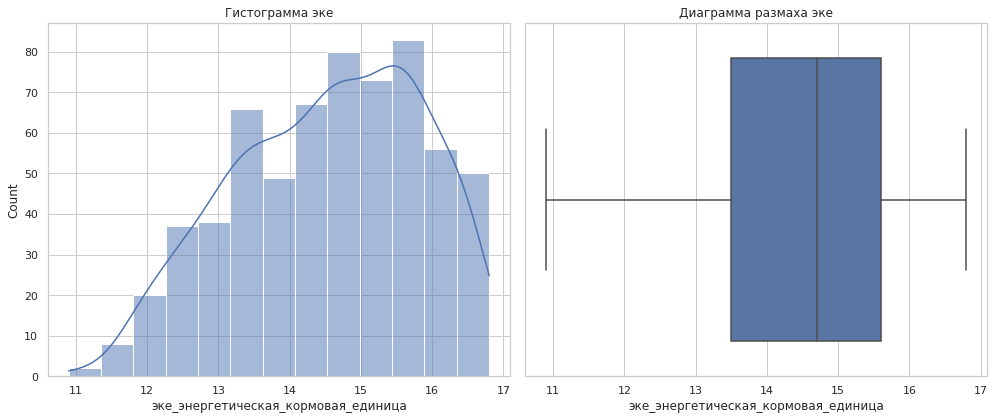

In [36]:
plot_distribution(data_main, 'эке_энергетическая_кормовая_единица', 'эке')

**Гистограммы ЭКЕ тоже напоминает нормальное распределение, но далеко не идеальное. Ящик с усами выбрасов не выявил.**

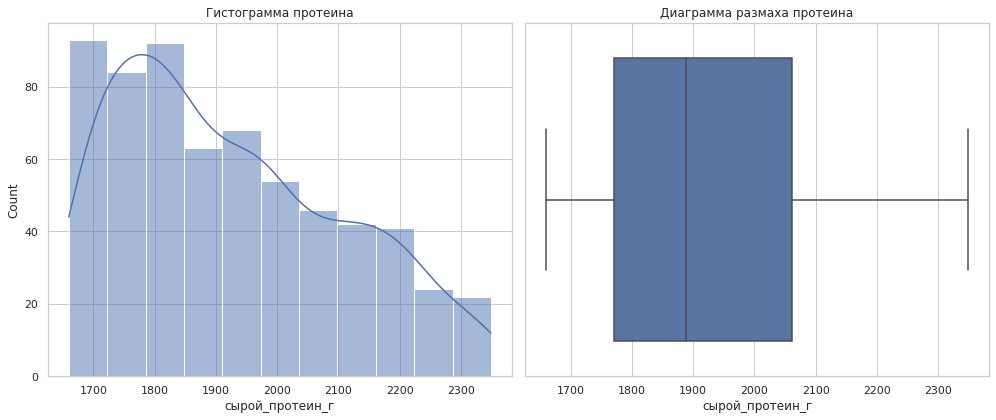

In [37]:
plot_distribution(data_main, 'cырой_протеин_г', 'протеина')

**Коробчатая диаграмма также не выявила наличие выбрасов для данного параметра, а по гистограмме можно сказать, что большая часть коров имеют маленькое количество протеина из представленного диапазона.**

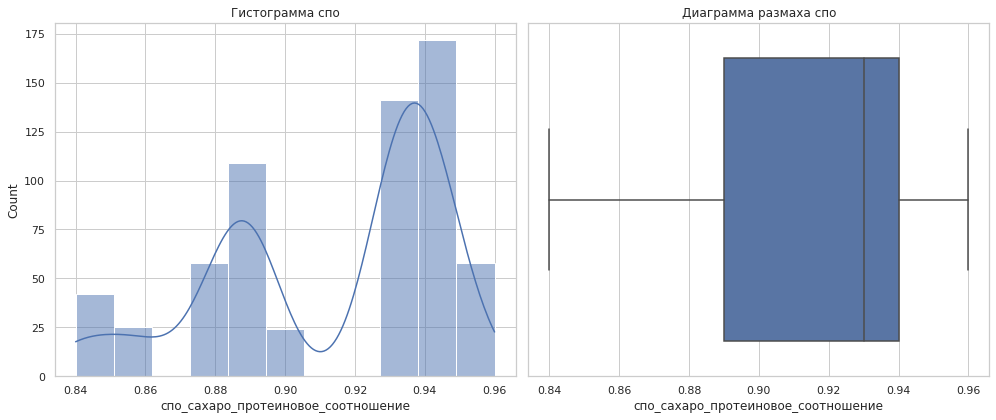

In [38]:
plot_distribution(data_main, 'спо_сахаро_протеиновое_соотношение', 'спо')

**Видна на гистограмме некоторая гармоническая зависимость количества коров с данным СПО от СПО. Выбросов не обнаружено.**

In [39]:
def plot_distribution_pie(data, column, title):
    # Подсчет количества коров каждой породы
    breed_counts = data[column].value_counts()

    # Построение круговой диаграммы
    plt.figure(figsize=(8, 8))
    plt.pie(breed_counts, labels=breed_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Круговая диаграмма {title}')
    plt.axis('equal')  # Для обеспечения круглой формы диаграммы
    plt.show()


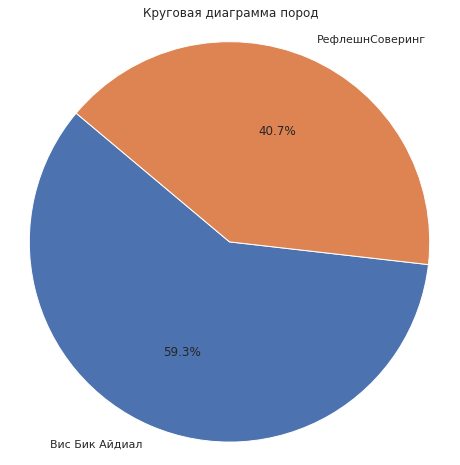

In [40]:
plot_distribution_pie(data_main, 'порода', 'пород')

**На ферме всего две породы коров и  преобладающий вид это Вис Бик Айдиал.**

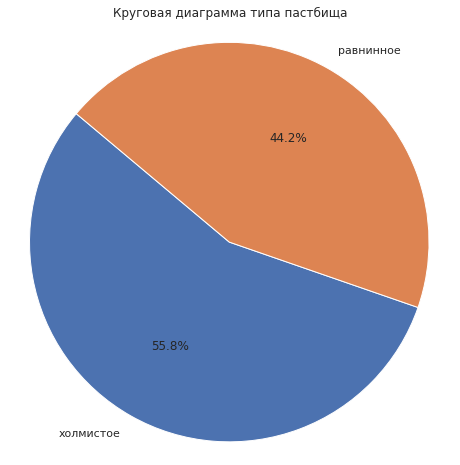

In [41]:
plot_distribution_pie(data_main, 'тип_пастбища', 'типа пастбища')

**У фермера в наличии 3 типа пастбищ, самым преобладающим является Холмистое, а менее преобладающее равнинное.**

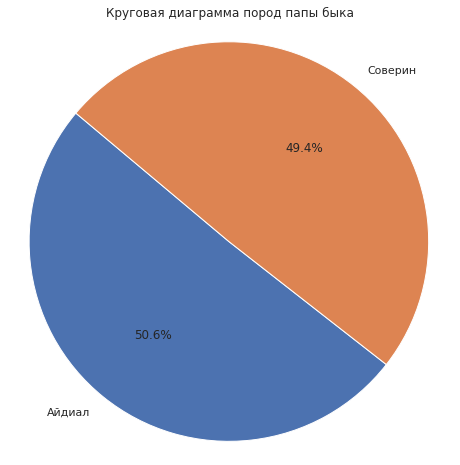

In [42]:
plot_distribution_pie(data_main, 'порода_папы_быка', 'пород папы быка')

**Пород пап таже две и их практические одинаковое количество, но Айдиалов чуть больше.**

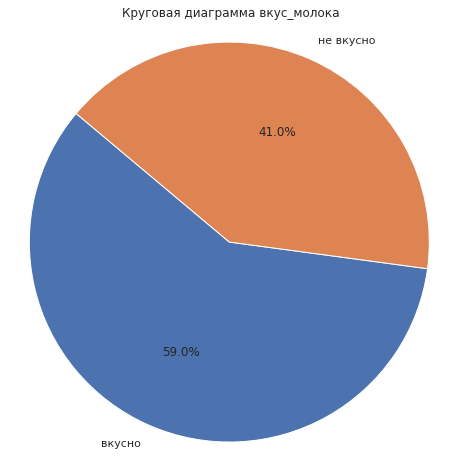

In [43]:
plot_distribution_pie(data_main, 'вкус_молока', 'вкус_молока')

**Большинство коров дают вкусное молоко, это не может не радовать), но процент коров с не вкусным молоком достаточно большой, следует за ними проследить.**

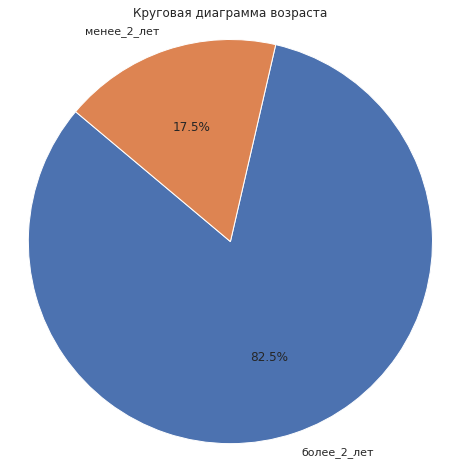

In [44]:
plot_distribution_pie(data_main, 'возраст', 'возраста')

**Возрастные коровы, которым больше 2 лет сильно доминируют над молодыми.**

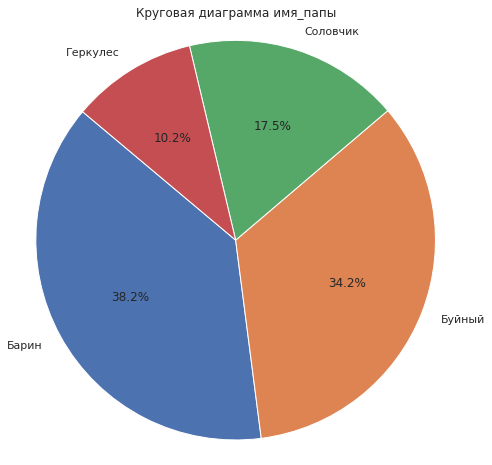

In [45]:
plot_distribution_pie(data_dad, 'имя_папы', 'имя_папы')

**Всего на ферме 4 типа имен для быка, доминирует имя Барин, а меньше всего быков Геркулес**

**Вывод по третьему шагу: По итогу проведения исследовательского анализа делаем вывод, что необходимо избавится от строк в датасете с аномальными значениями в столбцах удоя и жирности, которые в дальнейшем могут исказить качество обучаемой модели линейной регрессии.**

## Корреляционный анализ

In [46]:
data_main = data_main[(data_main['удой_кг'] < 45000) | (data_main['жирность_%'] > 3.3)]
data_main.corr(method='kendall')

,id,удой_кг,эке_энергетическая_кормовая_единица,cырой_протеин_г,спо_сахаро_протеиновое_соотношение,жирность_%,белок_%
id,1.000000,-0.002698,-0.014774,-0.024751,-0.015835,0.037278,0.003033
удой_кг,-0.002698,1.000000,0.566641,0.295729,0.595510,0.494140,-0.004750
эке_энергетическая_кормовая_единица,-0.014774,0.566641,1.000000,0.265449,0.578858,0.506118,-0.009910
cырой_протеин_г,-0.024751,0.295729,0.265449,1.000000,0.357744,0.278582,0.161488
спо_сахаро_протеиновое_соотношение,-0.015835,0.595510,0.578858,0.357744,1.000000,0.547567,0.083421
жирность_%,0.037278,0.494140,0.506118,0.278582,0.547567,1.000000,0.033451
белок_%,0.003033,-0.004750,-0.009910,0.161488,0.083421,0.033451,1.000000


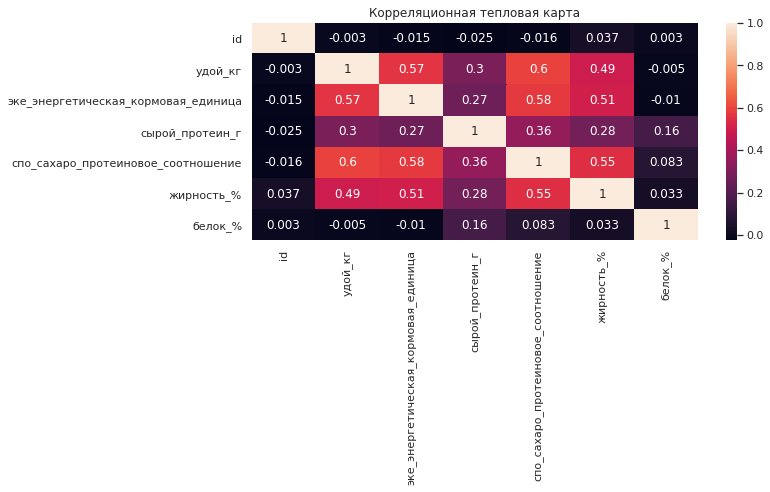

In [47]:
plt.figure(figsize=(10, 4))
sns.heatmap(round(data_main.corr(method='kendall'), 3), annot=True)
plt.title('Корреляционная тепловая карта')
plt.show()

**Обновление датасета и вывод корреляционной матрицы.**

**По тепловой карте оценим связь между удоем и остальными признаками. Наиболее сильная линейная связь с удоем наблюдается у  эке и спо, меньшую связь можно заметить c cырым протеином и жирностью.**

In [48]:
# Установка стиля для графиков
sns.set(style='whitegrid')
# Количественные признаки
quantitative_features = ['эке_энергетическая_кормовая_единица', 'cырой_протеин_г', 'спо_сахаро_протеиновое_соотношение',
                         'жирность_%', 'белок_%']
def scatter_plot(data, column):
    # Создание диаграмм рассеяния для удоя и всех количественных признаков
    for feature in quantitative_features:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=data, x=feature, y='удой_кг', hue=column, palette='viridis')
        plt.title(f'Диаграмма рассеяния: Удой, кг vs {feature}')
        plt.xlabel(feature)
        plt.ylabel('Удой, кг')
        plt.legend(title=column)
        plt.show()


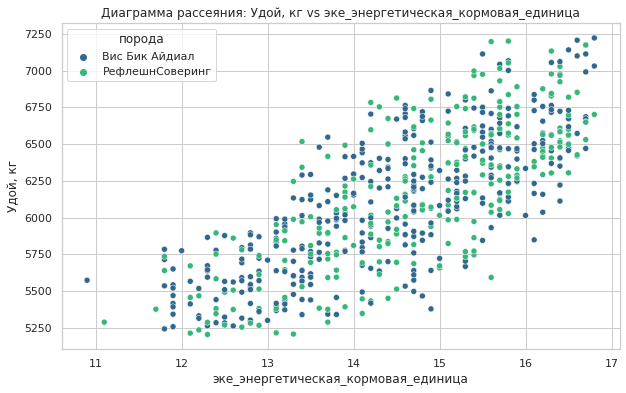

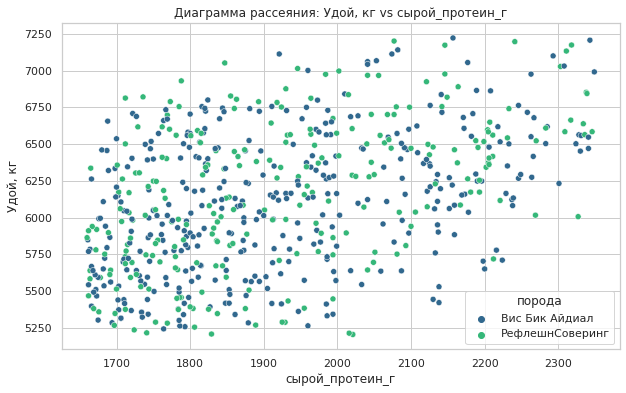

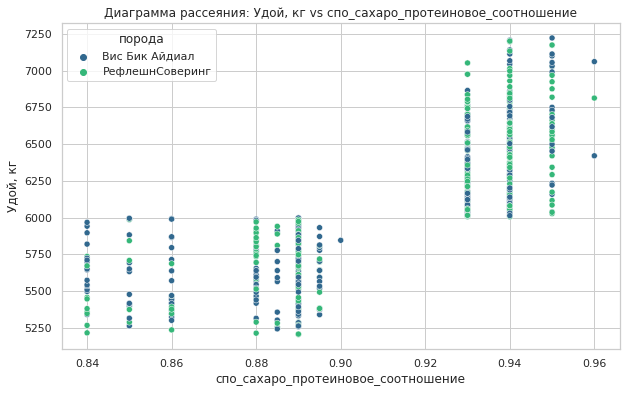

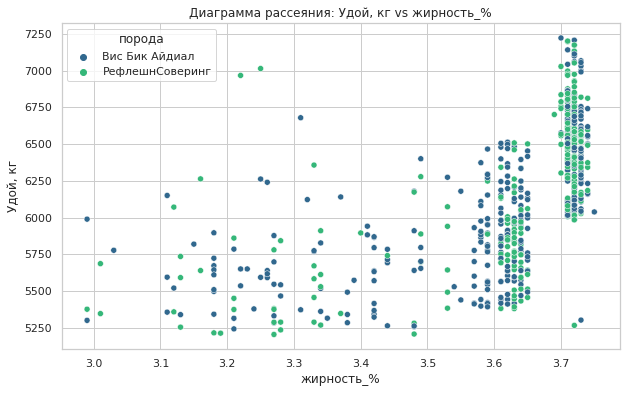

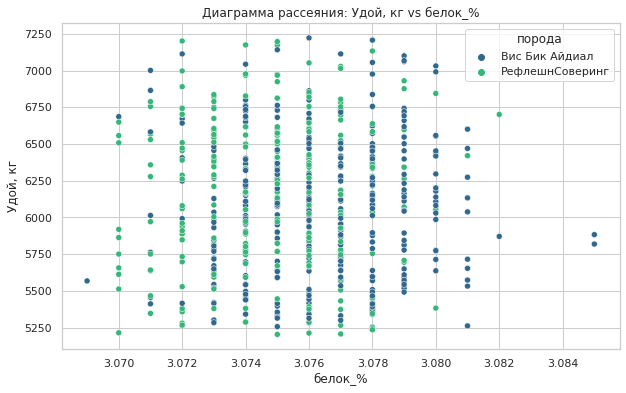

In [49]:
scatter_plot(data_main, 'порода')

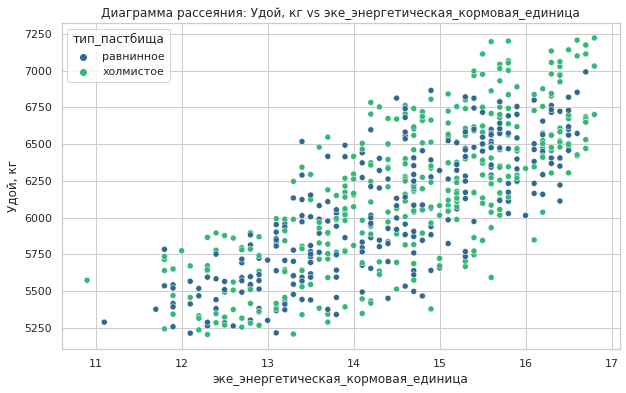

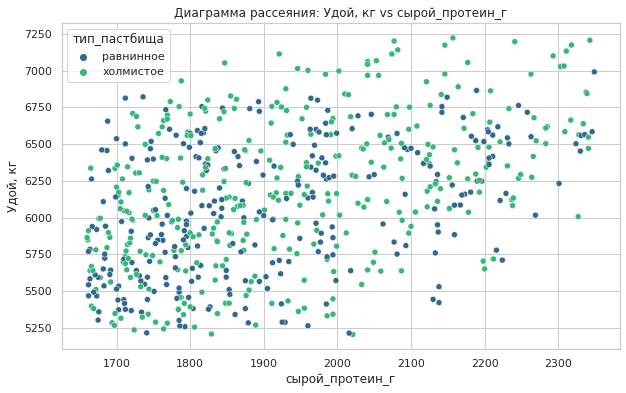

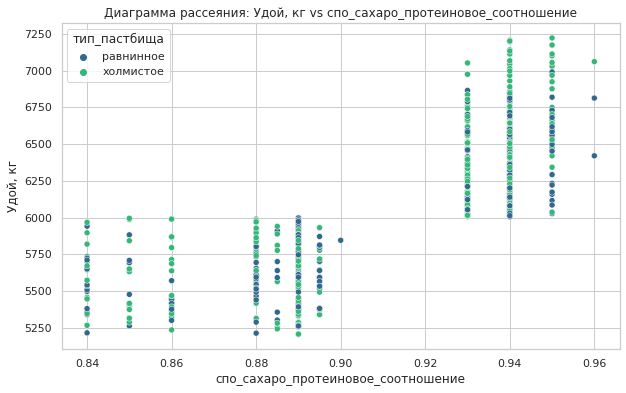

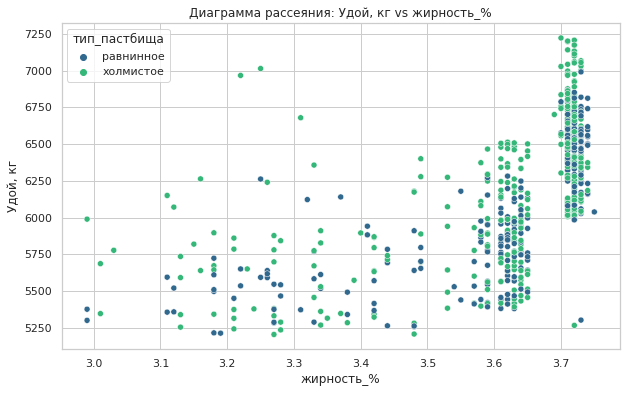

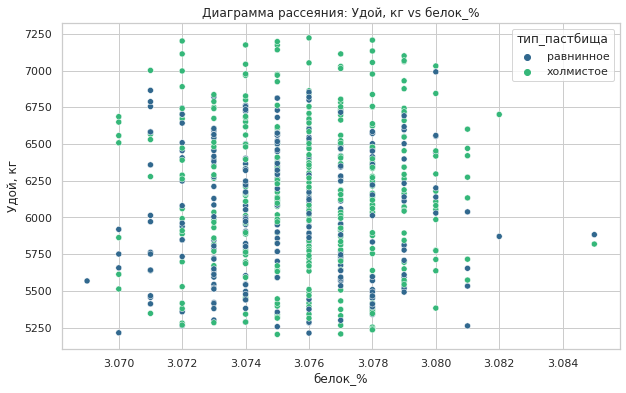

In [50]:
scatter_plot(data_main, 'тип_пастбища')

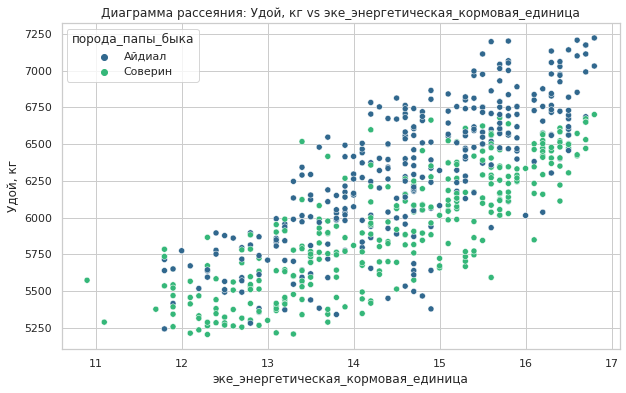

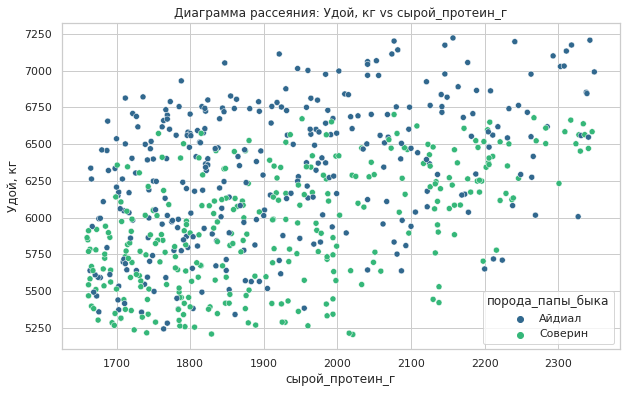

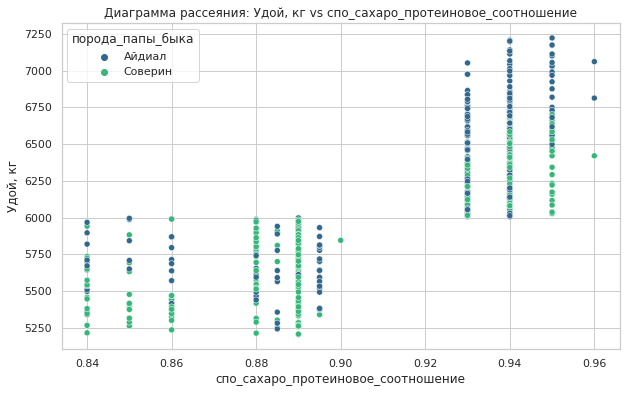

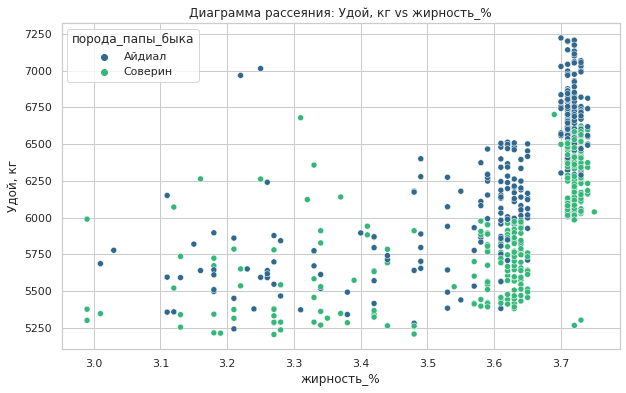

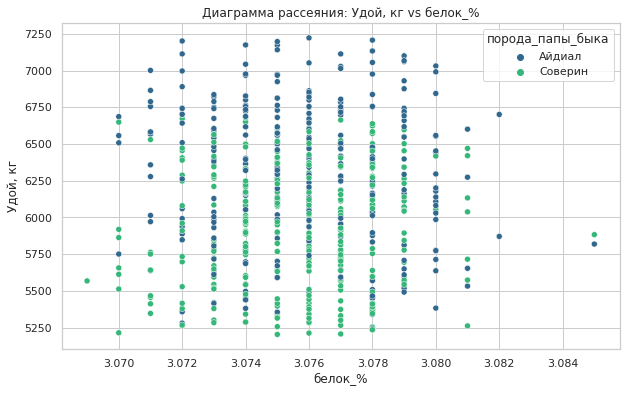

In [51]:
scatter_plot(data_main, 'порода_папы_быка')

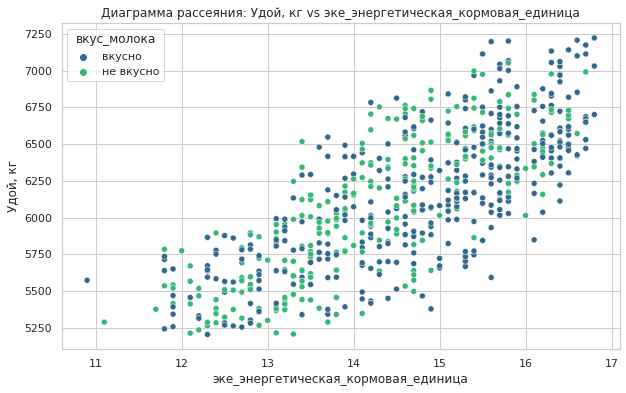

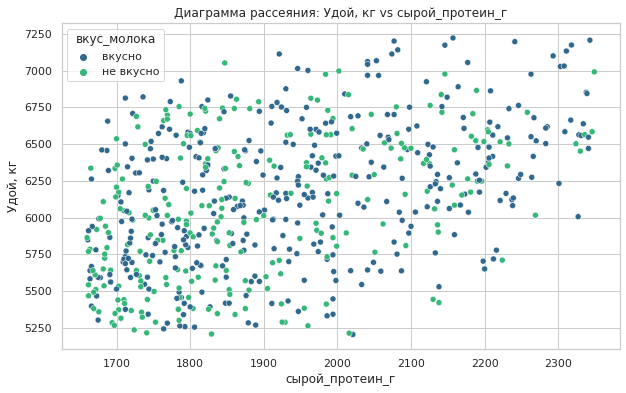

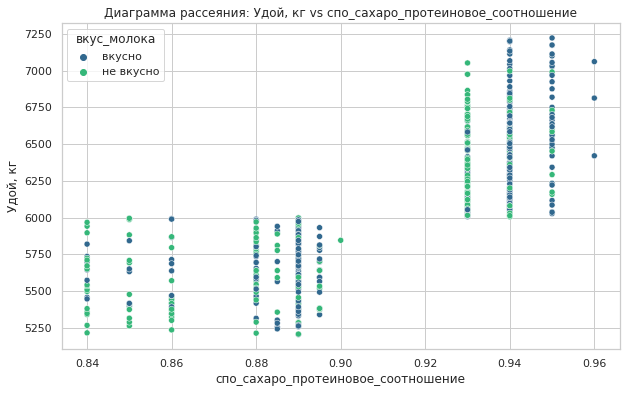

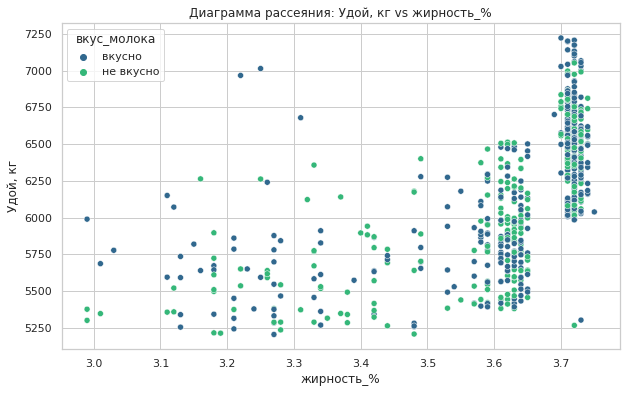

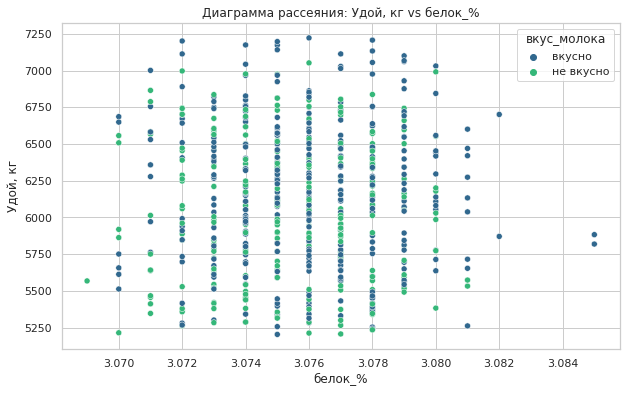

In [52]:
scatter_plot(data_main, 'вкус_молока')

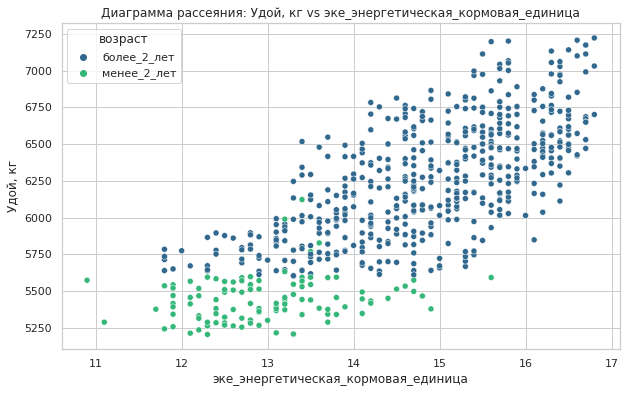

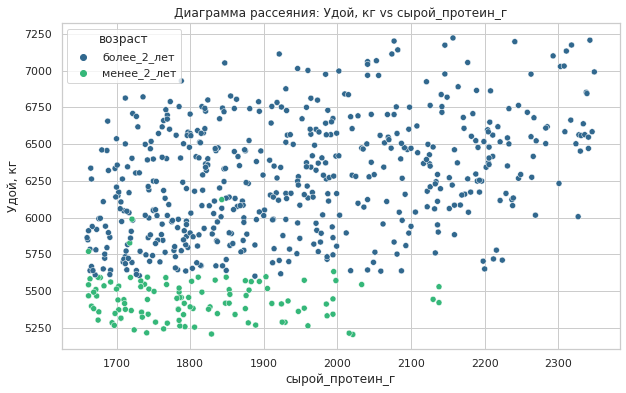

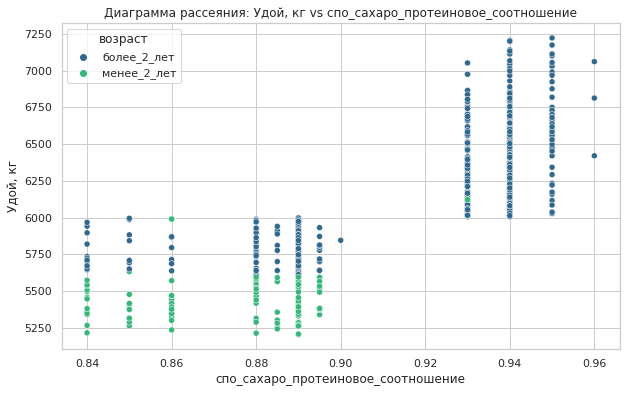

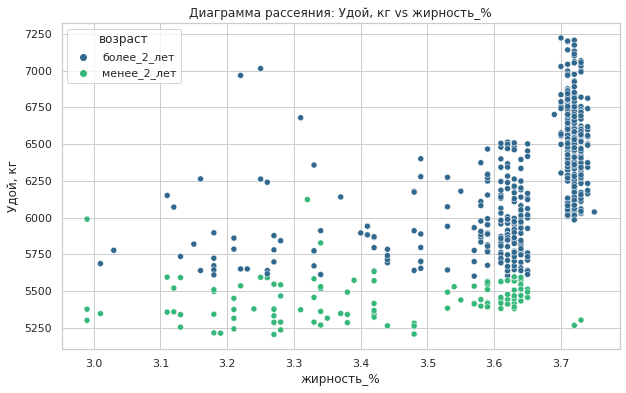

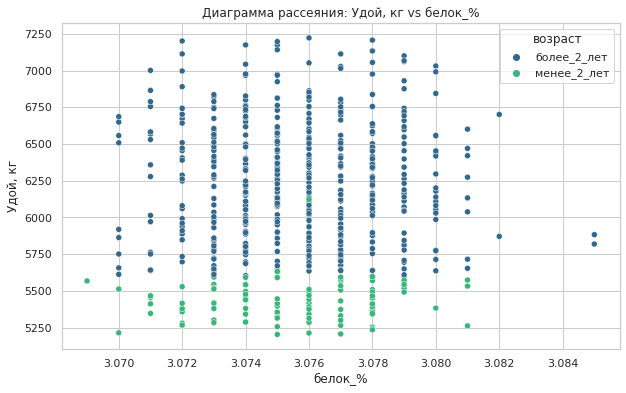

In [53]:
scatter_plot(data_main, 'возраст')

**По итогу полученных диаграмм рассеивания можно сказать, что зависимость удоя и эке имеет небольшой изгиб, поэтому возможно следует добавить признак, либо корня квадратного из эке, либо наоборот эке, возведеный в квадрат, сырой протеин наглядно не показывает линейной зависимости, но стоит заметить, что только в случае распределения по возрасту коров, можно заметить наглядность распределения коров, коровы с возрастом больлее двух лет дают больший удой, чем молодые коровы при одном и том же показателе протеина. При распределению по возрасту это справедливо для каждого графика. Зависимость удоя от СПО образует некоторые группы, сложно назвать эту зависимость линейной. Зависимость удоя от жирности дает также понять, что большая количество коров дают молоко с высокой жирностью, основная масса сгруппирована после 3,5 % жирности. Зависимость от белка также не имеет линейной зависимости, та как основная масса коров имеет молоко с белком от 3,072 до 3,079 % и количество в каждой категории 3,072-3,073-3,074-3,075-3,076-3,077-3,078-3,079% примерно одинковое.**

**Вывод по 4 части: В данной части проект рассмотрены зависимости целевого признака удоя от входных признаков, рассмотрена матрица корреляции и диаграммы рассеивания. Есть три связи ЭКЕ-СПО, ЭКЕ-жирность и СПО-жирность, которые отличаются высокой относительно других свзяей корреляцией, первая показывает 0.75, вторая 0.64 и третья 0.63, судить о мультиколлинеарности можно только между 2 и 3 случаем.**

## Обучение модели линейной регрессии

### Первая модель

In [54]:
#Разбиваем на таргет и признаки
y = data_main['удой_кг']
X = data_main.loc[:, ['спо_сахаро_протеиновое_соотношение', 
                      'эке_энергетическая_кормовая_единица',
                      'жирность_%',
                      'cырой_протеин_г',
                      'порода',
                      'тип_пастбища',
                      'порода_папы_быка',
                      'возраст']]

In [55]:
#Разбиваем данные на тестовую и тренировочную выборки
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
numerical_features_first = ['спо_сахаро_протеиновое_соотношение', 'эке_энергетическая_кормовая_единица', 'жирность_%', 'cырой_протеин_г']
categorical_features_first = ['порода',
                      'тип_пастбища',
                      'порода_папы_быка',
                      'возраст']

In [56]:
#Кодировка категориальных признаков
encoder_first = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_first.fit_transform(X_train[categorical_features_first])
X_test_ohe = encoder_first.transform(X_test[categorical_features_first])

In [57]:
#Преобразование количественных данных
scaler_first = StandardScaler()
X_train_scaled = scaler_first.fit_transform(X_train[numerical_features_first])
X_test_scaled = scaler_first.transform(X_test[numerical_features_first])

In [58]:
# Объединение
X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))

In [59]:
# Обучение модели линейной регрессии
model_first = LinearRegression()
model_first.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred_first = model_first.predict(X_test)

In [60]:
#Расчет метрик
r2_first = r2_score(y_pred_first, y_test)
MSE_first = mean_squared_error(y_pred_first, y_test)
MAE_first = mean_absolute_error(y_pred_first, y_test)
RMSE_first = mean_squared_error(y_pred_first, y_test, squared = False)

In [61]:
print('Метрики первой модели: ')
print(f'Детерминация : {r2_first}')
print(f'Среднеквадратичное отклонение : {MSE_first}')
print(f'Среднее абсолютное отклонение : {MAE_first}')
print(f'Среднеквадратичное отклонение под корнем : {RMSE_first}')

Метрики первой модели: 
Детерминация : 0.709102146430342
Среднеквадратичное отклонение : 43960.021611301665
Среднее абсолютное отклонение : 163.61998797909644
Среднеквадратичное отклонение под корнем : 209.6664532329902


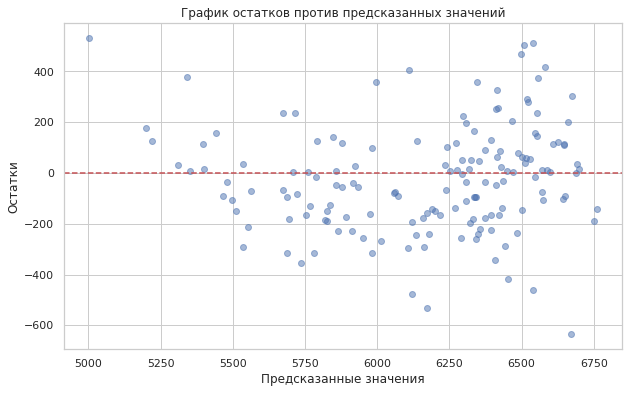

In [62]:
# Вычисление остатков
residuals_first = y_test - y_pred_first
# График остатков против предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_first, residuals_first, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков против предсказанных значений')
plt.show()

**По итогу обучения первой модели коэффициент детерминации равен 0.709 не лучший результат. Анализ остатков дает понять, что они распределены не равномерно, в основном сгруппированы на промежутке от -200 до 200 и на интервале предсказанных значений после 5750 и до 6750. Требуется корректировать данные подаваемые для обучения путем добавления вспомогательных признакв.**

### Вторая модель

#### Преобразование СПО

In [63]:
# Определение границы между кластерами
boundary_spo = 0.91  # Определили границу по диаграмме

In [64]:
# Преобразование СПО в бинарный категориальный признак
data_main['спо_категориальный'] = (data_main['спо_сахаро_протеиновое_соотношение'] > boundary_spo).astype(int)

#### Преобразование ЭКЕ

In [65]:
data_main['эке_квадрат'] = data_main['эке_энергетическая_кормовая_единица'] ** 2
data_main.head()

,id,удой_кг,эке_энергетическая_кормовая_единица,cырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,спо_категориальный,эке_квадрат
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84


#### Обучение

In [66]:
y = data_main['удой_кг']
X = data_main.loc[:, ['спо_категориальный', 
                      'эке_квадрат',
                      'жирность_%',
                      'cырой_протеин_г',
                      'порода',
                      'тип_пастбища',
                      'порода_папы_быка',
                      'возраст']]

In [67]:
X_train, X_test, y_train, y_test_second = train_test_split(X, y, random_state=RANDOM_STATE)
numerical_features_second = ['спо_категориальный', 'эке_квадрат', 'жирность_%','cырой_протеин_г']
categorical_features_second = ['порода',
                      'тип_пастбища',
                      'порода_папы_быка',
                      'возраст']

In [68]:
encoder_second = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_second.fit_transform(X_train[categorical_features_second])
X_test_ohe = encoder_second.transform(X_test[categorical_features_second])

In [69]:
scaler_second = StandardScaler()
X_train_scaled = scaler_second.fit_transform(X_train[numerical_features_second])
X_test_scaled = scaler_second.transform(X_test[numerical_features_second])

In [70]:
X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))

In [71]:
# Обучение модели линейной регрессии
model_second = LinearRegression()
model_second.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred_second = model_second.predict(X_test)

In [72]:
r2_second = r2_score(y_pred_second, y_test_second)
MSE_second = mean_squared_error(y_pred_second, y_test)
MAE_second = mean_absolute_error(y_pred_second, y_test)
RMSE_second = mean_squared_error(y_pred_second, y_test, squared = False)

In [73]:
print('Метрики второй модели: ')
print(f'Детерминация : {r2_second}')
print(f'Среднеквадратичное отклонение : {MSE_second}')
print(f'Среднее абсолютное отклонение : {MAE_second}')
print(f'Среднеквадратичное отклонение под корнем : {RMSE_second}')

Метрики второй модели: 
Детерминация : 0.7682948756002212
Среднеквадратичное отклонение : 37257.53811618768
Среднее абсолютное отклонение : 148.29630804145458
Среднеквадратичное отклонение под корнем : 193.0221182045925


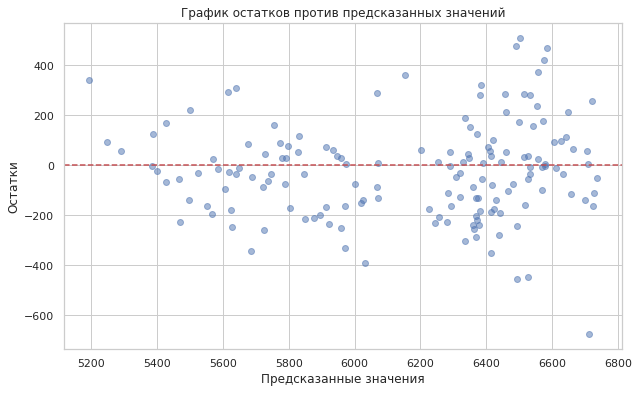

In [74]:
# Вычисление остатков
residuals_second = y_test_second - y_pred_second
# График остатков против предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_second, residuals_second, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков против предсказанных значений')
plt.show()

**По итогу обучения 2 модели было введено два вспомогательных признака. Первый: ранее была замечена что-то на подобии квадратичной зависимости удоя и ЭКЕ, поэтому введена величина ЭКЕ в квадрате. Вторая: на диаграмме рассеивания было замечено 2 кластера, которые явно были разделены некоторым граничным значением, по диаграмме он был определен - 0.91, за счет него было произведено разделение коров на два класса, которые имеют СПО больше 0.91 и меньше 0.91. С учетом введеных изменений обучена модель и посчитаны метрики. Коэффициент детерминации увеличился почти на 7%, а также остальные метрики, характеризующие отклонения уменьшились. Анализ остатков также показал результат лучше предыдущей модели. Остатки сместились влево и привели их плотность в более равномерное распределение, но все равно выделяется левый нижний угол, который пустует.**

### Третья модель

In [75]:
data_main_dad = pd.merge(data_main, data_dad, on='id')
data_main_dad.head()

,id,удой_кг,эке_энергетическая_кормовая_единица,cырой_протеин_г,спо_сахаро_протеиновое_соотношение,порода,тип_пастбища,порода_папы_быка,жирность_%,белок_%,вкус_молока,возраст,спо_категориальный,эке_квадрат,имя_папы
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,0,201.64,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,0,163.84,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,0,196.00,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,0,153.76,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,0,163.84,Барин


In [76]:
y = data_main_dad['удой_кг']
X = data_main_dad.loc[:, ['спо_категориальный', 
                      'эке_квадрат',
                      'жирность_%',
                      'cырой_протеин_г',
                      'порода',
                      'тип_пастбища',
                      'порода_папы_быка',
                      'возраст',
                      'имя_папы']]

In [77]:
X_train, X_test, y_train, y_test_third = train_test_split(X, y, random_state=RANDOM_STATE)
numerical_features_third = ['спо_категориальный', 'эке_квадрат', 'жирность_%', 'cырой_протеин_г']
categorical_features_third = ['порода',
                        'тип_пастбища',
                        'порода_папы_быка',
                        'возраст',
                        'имя_папы']

In [78]:
encoder_third = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_third.fit_transform(X_train[categorical_features_third])
X_test_ohe = encoder_third.transform(X_test[categorical_features_third])

In [79]:
scaler_third = StandardScaler()
X_train_scaled = scaler_third.fit_transform(X_train[numerical_features_third])
X_test_scaled = scaler_third.transform(X_test[numerical_features_third])

In [80]:
X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))

In [81]:
# Обучение модели линейной регрессии
model_third = LinearRegression()
model_third.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred_third = model_third.predict(X_test)

In [82]:
r2_third = r2_score(y_pred_third, y_test)
MSE_third = mean_squared_error(y_pred_third, y_test)
MAE_third = mean_absolute_error(y_pred_third, y_test)
RMSE_third = mean_squared_error(y_pred_third, y_test, squared = False)

In [83]:
print('Метрики третьей модели: ')
print(f'Детерминация : {r2_third}')
print(f'Среднеквадратичное отклонение : {MSE_third}')
print(f'Среднее абсолютное отклонение : {MAE_third}')
print(f'Среднеквадратичное отклонение под корнем : {RMSE_third}')

Метрики третьей модели: 
Детерминация : 0.7871990448140044
Среднеквадратичное отклонение : 35977.913649305134
Среднее абсолютное отклонение : 146.56435089757386
Среднеквадратичное отклонение под корнем : 189.67844803589347


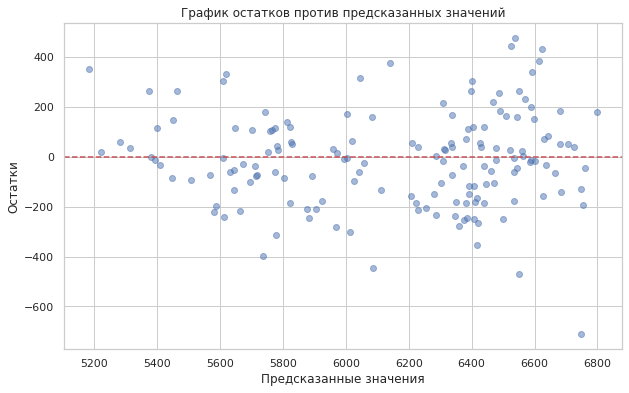

In [84]:
# Вычисление остатков
residuals_third = y_test - y_pred_third
# График остатков против предсказанных значений
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_third, residuals_third, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков против предсказанных значений')
plt.show()

**Третья модель обучена, она является эволюцией 2 модели, добавлен ещё один категориальный признак имя папы коровы. Коэффициент детерминации увеличился почти на 9% по сравнению с 1 моделью и на 2% по сравнению со второй моделью. Метрики, показывающие отклонение уменьшились. По распределению остатков можно также сказать, что их распределение чуть сместилось влево, где раньше была плотность меньше, чем справа.**

**Третья модель показывает лучшие метрики**

In [85]:
# Вычисление среднего и стандартного отклонения остатков
mean_residual = np.mean(residuals_third)
std_residual = np.std(residuals_third, ddof=1)
z_score = 1.96  
lower_bound = mean_residual - z_score * std_residual
upper_bound = mean_residual + z_score * std_residual

print(f'Доверительный интервал: ({lower_bound}, {upper_bound})')

Доверительный интервал: (-384.8592718763501, 359.37450802901316)


**Модель может предсказывать удой с недостатком значения на 385 единицы и с избытком на 359 единиц.**

In [86]:
# Определение доверительных интервалов для предсказаний на тестовой выборке
prediction_intervals = np.array([
    y_test_third + lower_bound,
    y_test_third + upper_bound]).T

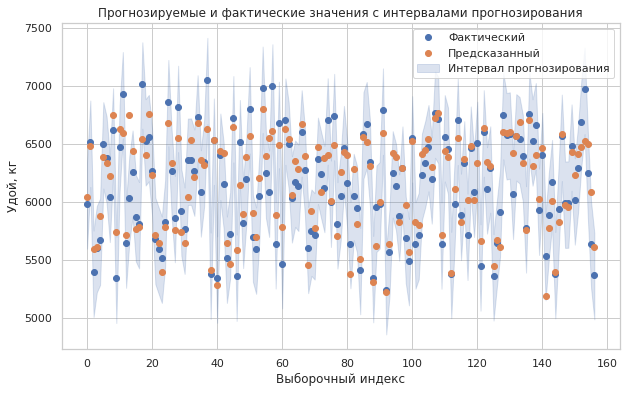

In [87]:
# Визуализация предсказаний и доверительных интервалов
plt.figure(figsize=(10, 6))
plt.plot(y_test_third.values, 'o', label='Фактический')
plt.plot(y_pred_third, 'o', label='Предсказанный')
plt.fill_between(range(len(y_pred_second)), prediction_intervals[:, 0], prediction_intervals[:, 1],
                 color='b', alpha=0.2, label='Интервал прогнозирования')
plt.legend()
plt.xlabel('Выборочный индекс')
plt.ylabel('Удой, кг')
plt.title('Прогнозируемые и фактические значения с интервалами прогнозирования')
plt.show()

### Прогнозирование удоя коров

In [88]:
data_buy['эке'] = data_main['эке_энергетическая_кормовая_единица'].mean() * 1.05
data_buy['спо'] = data_main['спо_сахаро_протеиновое_соотношение'].mean() * 1.05
data_buy['сырой_протеин_г'] = data_main['cырой_протеин_г'].mean() * 1.05

In [89]:
data_buy['эке_квадрат'] = data_buy['эке'] ** 2
data_buy['спо_категориальный'] = (data_buy['спо'] > boundary_spo).astype(int)

In [90]:
def preprocess_new_data(new_data, ohe, scaler, categorical_features, numerical_features):
    new_data_encoded = ohe.transform(new_data[categorical_features])
    new_data_scaled = scaler.transform(new_data[numerical_features])
    new_data_preprocessed = np.hstack((new_data_scaled, new_data_encoded))
    return new_data_preprocessed

In [91]:
data_buy['тип_пастбища'].unique()

array(['холмистое', 'равнинное'], dtype=object)

In [92]:
numerical_features = ['спо_категориальный', 'эке_квадрат', 'текущая_жирность_%', 'сырой_протеин_г']
categorical_features = ['порода',
                        'тип_пастбища',
                        'порода_папы_быка',
                        'возраст',
                        'имя_папы']
new_data_preprocessed = preprocess_new_data(data_buy, encoder_third, scaler_third, categorical_features, numerical_features)
# Получение предсказаний для новых данных
data_buy['предсказанный_удой'] = model_third.predict(new_data_preprocessed)
data_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст,эке,спо,сырой_протеин_г,эке_квадрат,спо_категориальный,предсказанный_удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6592.487002
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6358.263822
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6255.479529
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6538.111496
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6421.844445
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6592.487002
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6541.317029
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6361.273860
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6350.766936


**По итогу работы на 5 шаге: Было обучено 3 модели линейной регрессии, в каждой последующей добавлялись некоторые признаки, что приводило к улучшению результата. Анализ качества модели происходил на основе распределения остатков и метрик модели линейной регрессии. В итоге наилучшей моделью была выбрана третья, которая показала наибольший коэффициент детерминации и наименьшие отклоненя(стандарное и абсолютное), получен доверительный интервал от -385 до 359. Используя эту модель предсказан удой коров, которых фермер рассматривал на покупку, все коровы показали результатв более 6000 кг удоя в год. Теперь оценим вкус молока.**

## Обучение модели логистической регрессии

In [93]:
#Разбиваем на таргет и признаки
y = data_main.loc[:, 'вкус_молока']
X = data_main.drop('вкус_молока', axis=1)
y.head()

0       вкусно
1       вкусно
2    не вкусно
3    не вкусно
4       вкусно
Name: вкус_молока, dtype: object

In [94]:
# Создание пользовательского маппинга
class_mapping = {'вкусно': 1, 'не вкусно': 0}
# Применение маппинга к столбцу
y = y.map(class_mapping)

In [95]:
y[:5]

0    1
1    1
2    0
3    0
4    1
Name: вкус_молока, dtype: int64

**Так как в результате предсказаний мы получим набор 0 и 1, что будет соответствовать не вкусному молоку и вкусному соответсвтвенно. Для того, чтобы убедиться в корретности кодирования сравним вывод таргета выше с данным и видим первые две 1 соответствуют первым двум значениям вкусно и 0 соответствует 3 и 4 как не вкусно. С учетом этого будем оценивать качество модели.**

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)
numerical_features = ['спо_категориальный', 'эке_квадрат', 'белок_%', 'жирность_%']
categorical_features = ['порода',
                        'тип_пастбища',
                        'порода_папы_быка',
                        'возраст']

In [97]:
encoder_logistic = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder_logistic.fit_transform(X_train[categorical_features])
X_test_ohe = encoder_logistic.transform(X_test[categorical_features])

In [98]:
scaler_logistic = StandardScaler()
X_train_scaled = scaler_logistic.fit_transform(X_train[numerical_features])
X_test_scaled = scaler_logistic.transform(X_test[numerical_features])

In [99]:
X_train = np.hstack((X_train_scaled, X_train_ohe))
X_test = np.hstack((X_test_scaled, X_test_ohe))

In [100]:
#Обучение модели Логистической регрессии
clf = LogisticRegression()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

**Помним, что 1 - вкусно, 0 - не вкусно, значит в начальном предсказании те пороговые значения, которые меньше 0.5 предсказывают не вкусно, а больше 0.5 вкусно. С учетом этого необходимо подобрать будет оптимальный пороговый коэффициент.**

In [101]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f'Метрика accuracy: {accuracy}')
print(f'Метрика recall: {recall}')
print(f'Метрика precision: {precision}')

Метрика accuracy: 0.643312101910828
Метрика recall: 0.8636363636363636
Метрика precision: 0.6333333333333333


Text(30.5, 0.5, 'Настоящее')

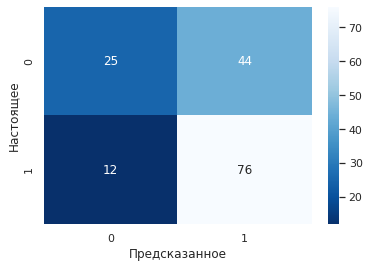

In [102]:
#Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Предсказанное')
plt.ylabel('Настоящее')

In [103]:
thresholds = [round(i, 2) for i in np.linspace(0.1, 1, num=100, endpoint=False)]
thresholds[:10]

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.15, 0.16, 0.17, 0.18]

In [104]:
# Оценка качества предсказаний для каждого порога
metrics = {'Threshold': [], 'Accuracy': [], 'Recall': [], 'Precision': []}

In [105]:
for threshold in thresholds:
    y_test_pred_binary = (y_prob >= threshold).astype(int)
    
    accuracy = accuracy_score(y_test, y_test_pred_binary)
    recall = recall_score(y_test, y_test_pred_binary)
    precision = precision_score(y_test, y_test_pred_binary)
    
    metrics['Threshold'].append(threshold)
    metrics['Accuracy'].append(accuracy)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
# Преобразование результатов в DataFrame
metrics_df = pd.DataFrame(metrics)

In [106]:
print(metrics_df.loc[metrics_df['Accuracy'].idxmax()])
print(metrics_df.loc[metrics_df['Recall'].idxmax()])
print(metrics_df.loc[metrics_df['Precision'].idxmax()])

Threshold    0.590000
Accuracy     0.687898
Recall       0.761364
Precision    0.705263
Name: 54, dtype: float64
Threshold    0.10000
Accuracy     0.56051
Recall       1.00000
Precision    0.56051
Name: 0, dtype: float64
Threshold    0.800000
Accuracy     0.484076
Recall       0.079545
Precision    1.000000
Name: 78, dtype: float64


**Получили разногласие между метриками, каждая из них предлагает своё пороговое значени. С учетом, что нам необходимо качество молока, а именно точнее знать вкус, значит нам необходимо уменьшить количество ложноположительных ответов, значит подойдет метрика precision.**

In [107]:
best_threshold = metrics_df.loc[metrics_df['Precision'].idxmax()]['Threshold']
best_threshold

0.8

**Проведем тестирование для полученного порогового значения.**

Text(30.5, 0.5, 'Настоящее')

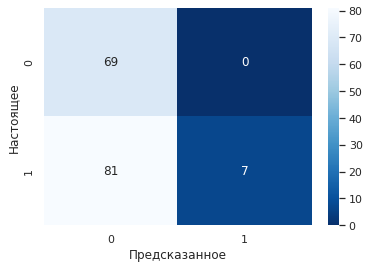

In [108]:
# Предсказания с лучшим порогом
y_test_pred_best = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_test_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Предсказанное')
plt.ylabel('Настоящее')

**В результате видим, что действительно ложноположительные ответы минимизировались максимально их 0, но всего 7 предсказанных ответов получилось истинно-положительными.**

In [109]:
best_threshold = 0.99

Text(30.5, 0.5, 'Настоящее')

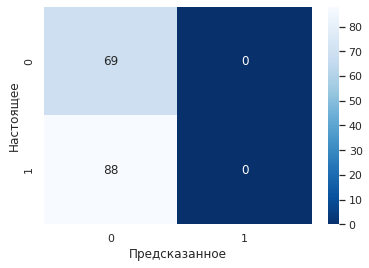

In [110]:
# Предсказания с лучшим порогом
y_test_pred_best = (y_prob >= best_threshold).astype(int)
cm = confusion_matrix(y_test, y_test_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.xlabel('Предсказанное')
plt.ylabel('Настоящее')

In [111]:
precision = precision_score(y_test, y_test_pred_best)
print(f'Метрика precision: {precision}')

Метрика precision: 0.0


In [112]:
y_test_pred_best = np.where(y_test_pred_best == 1, 'вкусно', 'не_вкусно')
y_test_pred_best[:5]

array(['не_вкусно', 'не_вкусно', 'не_вкусно', 'не_вкусно', 'не_вкусно'],
      dtype='<U9')

In [113]:
data_buy.head()

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст,эке,спо,сырой_протеин_г,эке_квадрат,спо_категориальный,предсказанный_удой
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6592.487002
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6358.263822
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6255.479529
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6538.111496
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380


In [114]:
def preprocess_new_data(new_data, ohe, scaler, categorical_features, numerical_features):
    new_data_encoded = ohe.transform(new_data[categorical_features])
    new_data_scaled = scaler.transform(new_data[numerical_features])
    new_data_preprocessed = np.hstack((new_data_scaled, new_data_encoded))
    return new_data_preprocessed

In [115]:
numerical_features = ['спо_категориальный', 'эке_квадрат', 'белок_%', 'жирность_%', 'удой_кг']
categorical_features = ['порода',
                        'тип_пастбища',
                        'порода_папы_быка',
                        'возраст']

In [116]:
numerical_features = ['спо_категориальный', 'эке_квадрат', 'текущая_жирность_%', 'сырой_протеин_г']
categorical_features = ['порода',
                        'тип_пастбища',
                        'порода_папы_быка',
                        'возраст']
new_data_preprocessed = (preprocess_new_data(data_buy, encoder_logistic, scaler_logistic, categorical_features,
                                             numerical_features))
y_pred_end = clf.predict(new_data_preprocessed)
y_prob_end = clf.predict_proba(new_data_preprocessed)[:, 1]
data_buy['вкус_молока'] = (y_prob_end >= best_threshold).astype(int)
data_buy['вкус_молока'] = np.where(data_buy['вкус_молока'] == 1, 'вкусно', 'не_вкусно')
data_buy.query('вкус_молока == "вкусно"')

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст,эке,спо,сырой_протеин_г,эке_квадрат,спо_категориальный,предсказанный_удой,вкус_молока
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380,вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6421.844445,вкусно
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6350.766936,вкусно
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6619.400652,вкусно
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6613.205572,вкусно
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6350.766936,вкусно
17,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6450.850444,вкусно
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380,вкусно


## Итоговые выводы

**Выведем тех коров, у которых удой больше 6000 кг и которые дают вкусное молоко, отметим их в исходном датасете data_buy**

In [117]:
data_buy.query('предсказанный_удой > 6000 and вкус_молока == "вкусно"')

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст,эке,спо,сырой_протеин_г,эке_квадрат,спо_категориальный,предсказанный_удой,вкус_молока
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380,вкусно
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6421.844445,вкусно
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6350.766936,вкусно
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6619.400652,вкусно
12,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.68,3.046,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6613.205572,вкусно
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6350.766936,вкусно
17,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.77,3.053,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6450.850444,вкусно
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380,вкусно


In [118]:
data_buy['оценка_коровы'] = '-'
data_buy.loc[data_buy.query('предсказанный_удой > 6000 and вкус_молока == "вкусно"').index, 'оценка_коровы'] = 'к покупке'

In [119]:
data_buy

,порода,тип_пастбища,порода_папы_быка,имя_папы,текущая_жирность_%,текущий_уровень_белок_%,возраст,эке,спо,сырой_протеин_г,эке_квадрат,спо_категориальный,предсказанный_удой,вкус_молока,оценка_коровы
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6592.487002,не_вкусно,-
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6358.263822,не_вкусно,-
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6255.479529,не_вкусно,-
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6538.111496,не_вкусно,-
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6530.648380,вкусно,к покупке
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6421.844445,вкусно,к покупке
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6592.487002,не_вкусно,-
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6541.317029,не_вкусно,-
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6361.273860,не_вкусно,-
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,233.361138,1,6350.766936,вкусно,к покупке


In [120]:
((start_shape - data_main.shape[0]) / data_main.shape[0]) * 100

0.9554140127388535


В ходе работы над проектом были рассмотрены данные о коровах фермы, всевозможных параметрах молока, которое они дают и о перспективах к покупке коров из отдельного списка. Произведены следующие действия:
- После просмотра данных, была сделана проверка на пропуски в данных, таких не было обнаружено. Далее посмотрели, если ли дубликаты в данных. Дубликаты явные обнаружены в основном датасете, после чего были удалены. Неяные дубликаты были обнаружены в двух столбцах с типом пастбища, где пасутся коровы и породами коров, все было корректно изменено на одно значение. Также столбцы были в не очень пригодном для работы состоянии, поэтому все столбцы были переименованы. Загрузка данных была осуществлена так, чтобы столбцы корректно разделились и вещественные числа были записаны в правильном виде.
- Далее проведен исследовательский анализ данных, который включал в себя:
  - просмотр всех статистическиз параметров основного датасета; 
  - были построены гистограммы для всех количественнх признаков;
  - построены графики и коробчатые диаграммы для каждого количественного признака, с помощью которых были выявлены выбросы в      некоторых столбцах, датасет был изменен с перспективой улучшить данные от выбивающихся значений;
  - построены круговые диаграммы для категориальных признаков; 
- После этого проведен корреляционный анализ:
  - построена корреляционная матрица и соответствующая ей тепловая карта, чтобы было наглядно видно, какие линейные связи хорошо выделяются;
  - выведены диаграммы рассеяния в зависимости от категориальных признаков между таргетом удой и количественными признаками, можно было заметить несколько интересных зависимостей;
  - наиболее сильная корреляционная зависимость между удоем получилась с ЭКЕ, СПО, жирностью и сырым протеином, но с точки зрения диаграммы рассеяния была замечена квадратичная зависимость с ЭКЕ и кластериазация с СПО.
  - для мультиколлинеарность рассмотрены три связи ЭКЕ-СПО, ЭКЕ-жирность и СПО-жирность, которые отличаются высокой относительно других свзяей корреляцией, первая показывает 0.75, вторая 0.64 и третья 0.63, судить о мультиколлинеарности можно только между 2 и 3 случаем.
- На основе всех вышеперечисленных действий было обучено 3 модели линейной регрессии, главное целью который являлось спрогнозировать удой коров, которые находятся в списке для покупки новых экземпляров:
  - 1 модель: По итогу обучения первой модели коэффициент детерминации равен 0.709, не лучший результат. Анализ остатков дает понять, что они распределены не равномерно, в основном сгруппированы на промежутке от -200 до 200 и на интервале предсказанных значений после 5750 и до 6750. Требуется корректировать данные подаваемые для обучения путем добавления вспомогательных признакв.
  - 2 модель: Было произведено несколько изменений в признаках, вместо просто ЭКЕ, использовался ЭКЕ в квадрате, так как выше было упомянуто, что диаграмма рассеивания показала, что то на подобии квадратичной зависимости, а также с СПО проведена кластеризация, выделено две категории, значения СПО больше 0.91 и меньше 0.91. С учетом введеных изменений обучена модель и посчитаны метрики. Коэффициент детерминации увеличился почти на 7%, а также остальные метрики, характеризующие отклонения уменьшились. Анализ остатков также показал результат лучше предыдущей модели. Остатки сместились влево и привели их плотность в более равномерное распределение, но все равно выделяется левый нижний угол, который пустует.
  - 3 модель: Третья модель обучена, она является эволюцией 2 модели, добавлен ещё один категориальный признак имя папы коровы. Коэффициент детерминации увеличился почти на 9% по сравнению с 1 моделью и на 2% по сравнению со второй моделью. Метрики, показывающие отклонение уменьшились. По распределению остатков можно также сказать, что их распределение чуть сместилось влево, где раньше была плотность меньше, чем справа.
  По итогу наилучшей показала себя 3 модель, она и была использована для прогнозирования удоя коров. Данные были добавлены в соответствующую таблицу.
- Мало было узнать удой коров, необходимо понять вкусное ли молоко или нет. Для этого была обучена модель логистической регрессии. Стоит учесть, что фермеру принципиально было понимать список коров, которые дают именно вкусное молоко. Из всех возможных признаков может подойти только метрика precision, для увеличения которой, нужно минимизировать ложно-положительные ответы или вообще обратить их в 0, то есть модель говорит, что молоко вкусное, но по факту это не так. Поэтому проведено несколько тестов:
  - пороговое значение разделения переменных по умолчанию 0.5: в итоге получаем метрику precision = 0.63. с учетом, что не было произведено никаких изменений.
  - далее нашли пороговое значение, при котором нужная метрика обращается в 1, то есть мы обнулили ложно положительные результаты, оно оказалось равным 0.8. При таком выборе порогового значения модель предугадала 13 коров, которых потенциально мог купить фермер.
  - далее увеличили порог до 0.99, таким образом, получили уже 8 потенциальных коров для покупки, тем самым выбрали самых лучших коров.
  
  
 Отметки каких коров лучше всего купить отмечены в соответствующей таблице в отдельном стобце.
 
 
В итоге, фермер может полагаться на предлагаемый ему выбор коров к покупке и быть уверен в том, что получит качественный продукт с купленных коров.
 
Результаты модели для фермера:


 К покупке фермеру предлагается 8 коров из представленного списка, которые удовлетворяют заданным требованиям, все коровы способны давать удой больше 6000 кг, но не каждая была готова давать вкусное молоко, по итогу в 8 купленных коровах фермер не разочаруется.

<b>
    
    
    
</b>